In [ ]:
!pip install q keras==2.1.2

     |████████████████████████████████| 307kB 8.3MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [ ]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8664008872573744978, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14353362599316884452
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2113641021516904448
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14949928141
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13164202408567892936
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
# check use from CPU/GPU

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!nvidia-smi

Fri Jul 30 11:21:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    28W /  70W |    104MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# data analysis pkg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Word vectorization and splitting dataset
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Building sequential model
from keras.models import Model
# from keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D
from keras.layers import Embedding, Dense, Dropout, Input
from keras.layers import LeakyReLU, Input, Flatten, LSTM, SpatialDropout1D, Bidirectional

# Cofigurations
from keras.callbacks import ModelCheckpoint

# import metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score
from sklearn.metrics import roc_curve, auc, confusion_matrix

from Capsule_Keras import *

# Avoiding warnings
import warnings
import os
########### Prevent Warnings ###########
warnings.filterwarnings(action='ignore')
########### Prevent Warnings ###########

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# df = pd.read_csv('drive/MyDrive/NLP/data_test.csv')
# df.title = df.title.astype('str')
# df.text = df.text.astype('str')
# df.comment = df.comment.astype('str')
# df.rate = df.rate.astype('category')

df = pd.read_csv('drive/MyDrive/NLP/cleaned_dataset.csv')
df.comment = df.comment.astype('str')
df.recommend = df.recommend.astype('category')

In [ ]:
# features = df.columns.tolist()[:-1]
# features = ['text']
# label = ['rate']

# X_train, X_test, Y_train, Y_test = train_test_split(df[features], df[label], test_size=0.2,random_state=41)

# X_train = [text for text in X_train.text]
# Y_train = [label for label in Y_train.rate]

# X_test = [text for text in X_test.text]
# Y_test = [label for label in Y_test.rate]

# features = df.columns.tolist()[:-1]
features = ['comment']
label = ['recommend']

X_train, X_test, Y_train, Y_test = train_test_split(df[features], df[label], test_size=0.2,random_state=41)

X_train = [text for text in X_train.comment]
Y_train = [label for label in Y_train.recommend]

X_test = [text for text in X_test.comment]
Y_test = [label for label in Y_test.recommend]

In [ ]:
n_dim = 64
n_unique_words = 8000
max_text_length = 150
pad_type = trunc_type = 'pre'

# gru_len = 256
Routings = 3
Num_capsule = 12
Dim_capsule = 10
dropout_p = 0.15
# rate_drop_dense = 0.15
drop_embed = 0.2

# max_features = 10000
# maxlen = 1000
# embed_size = 128

In [ ]:
tok = Tokenizer(num_words=n_unique_words, lower=False)
tok.fit_on_texts(X_train)

train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_text_length, padding=pad_type)

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_text_length)


In [ ]:
train_sequences_matrix.shape

(40832, 150)

In [ ]:
def get_model():
#     input1 = Input(shape=(maxlen,))
#     embed_layer = Embedding(max_features,
#                             embed_size,
#                             input_length=maxlen)(input1)
#     embed_layer = SpatialDropout1D(rate_drop_dense)(embed_layer)
    
    input_layer = Input(shape=(max_text_length,), dtype='int16', name='input')
    
    embedding_layer = Embedding(n_unique_words, n_dim, input_length=max_text_length, name='embedding')(input_layer)
    drop_embedding_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)

#     x = Bidirectional(LSTM(256,return_sequences=True))(drop_embedding_layer)
#     capsule = Capsule(
#         num_capsule=Num_capsule,
#         dim_capsule=Dim_capsule,
#         routings=Routings,
#         share_weights=True)(x)

#     capsule = Flatten()(capsule)
#     capsule = Dropout(dropout_p)(capsule)
#     capsule = LeakyReLU()(capsule)

#     x = Flatten()(x)
#     # output = Dense(1, activation='sigmoid')(x)
#     output = Dense(1, activation='sigmoid')(x)
#     model = Model(inputs=input1, outputs=output)
#     model.compile(
#         loss='binary_crossentropy',
#         optimizer='adam',
#         metrics=['accuracy'])
#     model.summary()

    x = Bidirectional(LSTM(256,return_sequences=True))(drop_embedding_layer)
    capsule = Capsule(
        num_capsule=Num_capsule,
        dim_capsule=Dim_capsule,
        routings=Routings,
        share_weights=True)(x)

    capsule = Flatten()(capsule)
    capsule = Dropout(dropout_p)(capsule)
#     capsule = LeakyReLU()(capsule)
    capsule = Dense(16, activation="relu")(capsule)
    capsule = Dense(1, activation = "sigmoid")(capsule)

#     x = Flatten()(x)
#     output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=capsule)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        # optimizer=Adam(lr=1e-3),        
        metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
model = get_model()
batch_size = 32
epochs = 15

history = model.fit(train_sequences_matrix, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(test_sequences_matrix, Y_test))
test_sequences_matrix = train_sequences_matrix
y_hat = model.predict(test_sequences_matrix)

W0730 11:24:50.008107 139716985747328 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:497: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 11:24:50.014405 139716985747328 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3636: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 11:24:50.034359 139716985747328 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:118: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 11:24:50.041044 139716985747328 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3019: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Pleas

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 150)               0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 64)           512000    
_________________________________________________________________
drop_embed (SpatialDropout1D (None, 150, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 512)          657408    
_________________________________________________________________
capsule_1 (Capsule)          (None, 12, 10)            61440     
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
__________

W0730 11:24:52.068068 139716985747328 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:958: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0730 11:24:52.080332 139716985747328 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:680: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0730 11:24:52.162022 139716985747328 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:945: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0730 11:24:52.274869 139716985747328 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:2378: The name tf.Session i

Train on 40832 samples, validate on 10209 samples
Epoch 1/15
40832/40832 [==============================] - 457s 11ms/step - loss: 0.5296 - acc: 0.7447 - val_loss: 0.4567 - val_acc: 0.7977
Epoch 2/15
40832/40832 [==============================] - 440s 11ms/step - loss: 0.4188 - acc: 0.8171 - val_loss: 0.3737 - val_acc: 0.8240
Epoch 3/15
40832/40832 [==============================] - 443s 11ms/step - loss: 0.3020 - acc: 0.8762 - val_loss: 0.3585 - val_acc: 0.8505
Epoch 4/15
40832/40832 [==============================] - 446s 11ms/step - loss: 0.2351 - acc: 0.9089 - val_loss: 0.2760 - val_acc: 0.8916
Epoch 5/15
40832/40832 [==============================] - 451s 11ms/step - loss: 0.2031 - acc: 0.9241 - val_loss: 0.2748 - val_acc: 0.8917
Epoch 6/15
40832/40832 [==============================] - 438s 11ms/step - loss: 0.1787 - acc: 0.9357 - val_loss: 0.2995 - val_acc: 0.8893
Epoch 7/15
40832/40832 [==============================] - 435s 11ms/step - loss: 0.1591 - acc: 0.9439 - val_loss: 0.

In [ ]:
final_accuracy = history.history["val_acc"][-5:]
print("FINAL VALL_ACCURACY MEAN-5: ", np.mean(final_accuracy))

('FINAL VALL_ACCURACY MEAN-5: ', 0.8765794886864532)


In [ ]:
final_accuracy = history.history["acc"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

('FINAL ACCURACY MEAN-5: ', 0.9707337382445141)


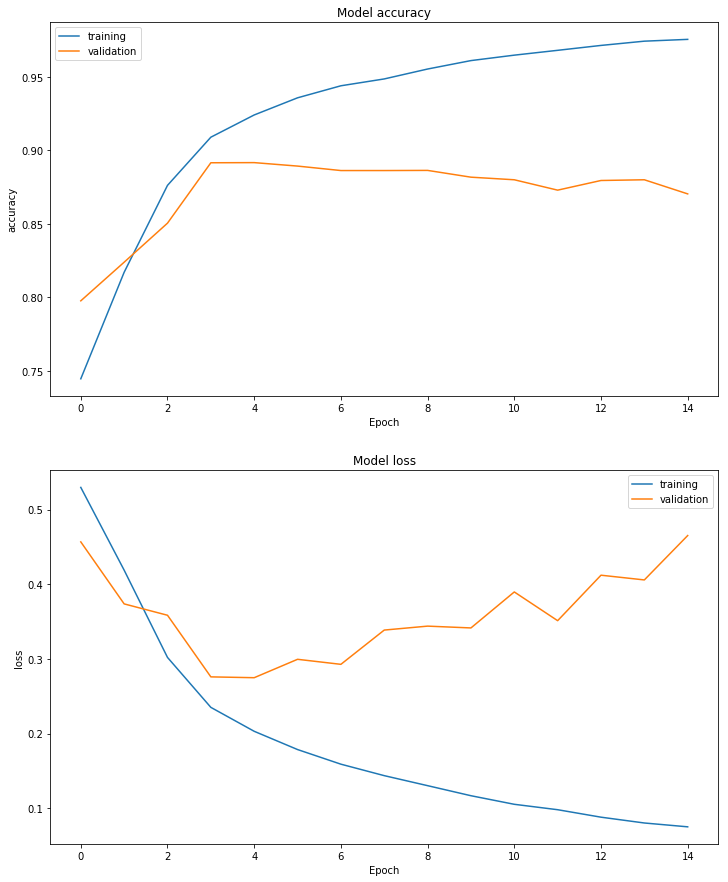

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('Model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('Epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,12))
plt.tight_layout()
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

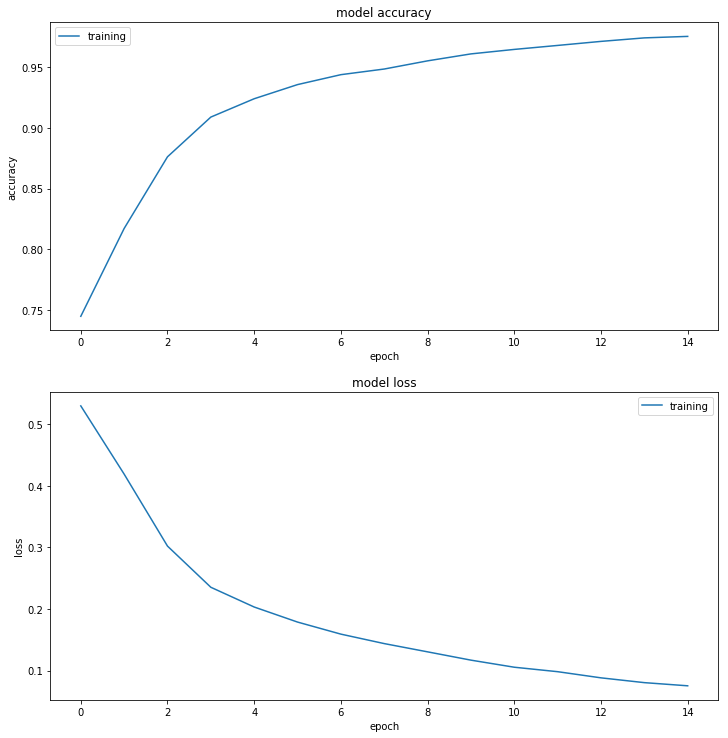

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
# if __name__ == '__main__':
#     main()

In [ ]:
# model = get_model()

# y_hat = model.predict(test_sequences_matrix)

In [ ]:
RoundIntPredicted = np.where(y_hat > 0.5, 1, 0)
print (np.array(RoundIntPredicted))
# print(y_hat)

[[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [0]]


In [ ]:
auc = roc_auc_score(Y_train, RoundIntPredicted)*100.0
print(auc)

97.88601387471854


fpr, tpr, thresholds = roc_curve(Y_train,RoundIntPredicted )
roc_auc = auc(fpr, tpr)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

confusion = confusion_matrix(Y_train, RoundIntPredicted)
print(confusion)

# True Positives
TP = confusion[1, 1]
# True Negatives
TN = confusion[0, 0]
# False Positives
FP = confusion[0, 1]
# False Negatives
FN = confusion[1, 0]

#Accuracy 
print("Accuracy of Hybrid LSTM_Capsule Network:")
print(accuracy_score(Y_train, RoundIntPredicted))
print("=======================")

# Sensitivity 
print("Sensitivity of Hybrid LSTM_Capsule Network:")
print(recall_score(Y_train, RoundIntPredicted))
print("=======================")


# specificity 
print("specificity of Hybrid LSTM_Capsule Network:")
print(TN / float(TN + FP))
print("=======================")

# print(sensitivity("Sensitivity score :", y_test, predicted_y))

[[12264   244]
 [  645 27679]]
Accuracy of Hybrid LSTM_Capsule Network:
0.9782278605015674
Sensitivity of Hybrid LSTM_Capsule Network:
0.9772277926846491
specificity of Hybrid LSTM_Capsule Network:
0.9804924848097217


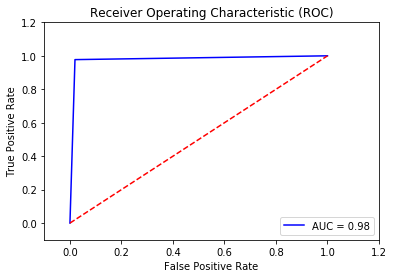

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(Y_train, RoundIntPredicted, average="macro"):

   
    y_test = lb.transform(Y_train)
    RoundIntPredicted = lb.transform(RoundIntPredicted)

    return roc_auc_score(Y_train, RoundIntPredicted, average=average)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, RoundIntPredicted)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


[[12264   244]
 [  645 27679]]


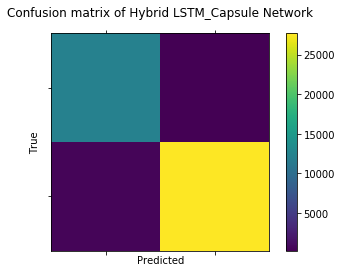

In [ ]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(Y_train, RoundIntPredicted)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of Hybrid LSTM_Capsule Network')
fig.colorbar(cax)
ax.set_xticklabels([''] )
ax.set_yticklabels([''] )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
RoundIntPredicted = np.where(y_hat > 0.5, 1, 0)
print(RoundIntPredicted[23])
print(Y_test[23])

[1]
1


In [ ]:
auc = roc_auc_score(Y_train, RoundIntPredicted)*100.0
print(auc)

97.88601387471854


In [ ]:
fpr, tpr, thresholds = roc_curve(Y_train,RoundIntPredicted )
roc_auc = auc(fpr, tpr)
print(tpr)
print(fpr)

TypeError: ignored

In [ ]:
label = 'Hybrid LSTM CapsuleNet AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.ylabel('True Positive Rate', fontsize = 16)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

NameError: ignored

[[12264   244]
 [  645 27679]]


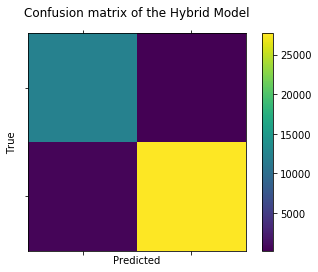

In [ ]:
cm = confusion_matrix(Y_train, RoundIntPredicted)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the Hybrid Model')
fig.colorbar(cax)
ax.set_xticklabels([''] )
ax.set_yticklabels([''] )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def calculate_sensitivity_specificity(Y_train, RoundIntPredicted):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = Y_train == 1
    actual_neg = Y_train == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (RoundIntPredicted == 1) & (actual_pos)
    false_pos = (RoundIntPredicted == 1) & (actual_neg)
    true_neg = (RoundIntPredicted == 0) & (actual_neg)
    false_neg = (RoundIntPredicted == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(RoundIntPredicted == Y_train)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy

In [ ]:
# sensitivity, specificity, accuracy = calculate_sensitivity_specificity(Y_train, RoundIntPredicted)
# print ('Sensitivity:', sensitivity)
# print ('Specificity:', specificity)
# print ('Accuracy:', accuracy)